Task:\
-Smooth map using Gaussian filtre.\
-Pick out 20000 hot and 20000 cold points on map\
-In local peak of angular size 5x5 degrees, calculate T, Qr and Ur and add

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import camb
import healpy as hp
from camb import model, initialpower

planck2018pars = camb.read_ini("planck_2018.ini")
planck2018 = camb.get_results(planck2018pars)

In [2]:
# unnormalised Cl
powers = planck2018.get_cmb_power_spectra(planck2018pars, CMB_unit="muK", raw_cl=True)

# total power spectrum
aCl_Total = powers["total"]

# l starts from 0 (monopole)
lmax = aCl_Total.shape[0] - 1
# l steps
aL = np.arange(lmax + 1)

In [3]:
almT, almE, almB = hp.synalm(
    [
        np.array(aCl_Total[:, 0]),
        np.array(aCl_Total[:, 1]),
        np.array(aCl_Total[:, 2]),
        np.array(aCl_Total[:, 3]),
    ],
    new=True,
)
sharp_map = hp.alm2map([almT, almE, almB], nside=512)
smooth = hp.smoothing(sharp_map, 0.5 * np.pi / 180)
print(np.min(smooth[0]), np.max(smooth[0]))
print(np.min(smooth[1]), np.max(smooth[1]))
print(np.min(smooth[2]), np.max(smooth[2]))

-435.0044461315571 403.88109292903954
-5.255975859025021 5.617102222477688
-5.660117169293297 5.437177779622585


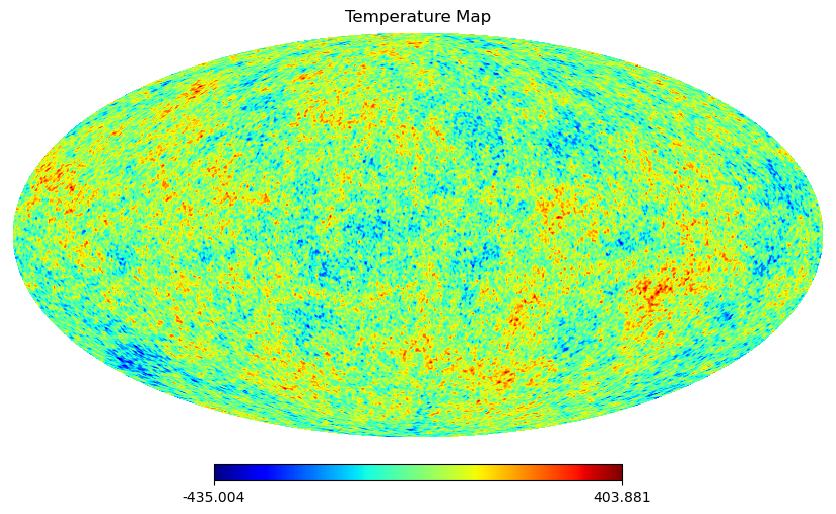

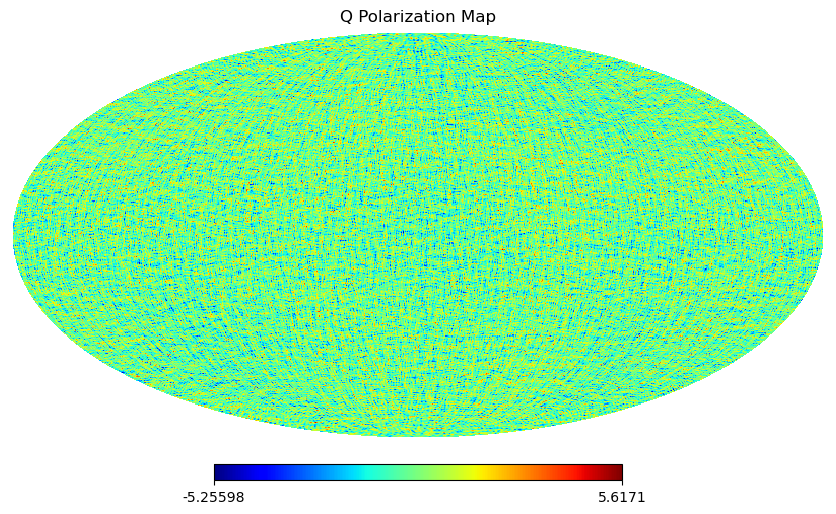

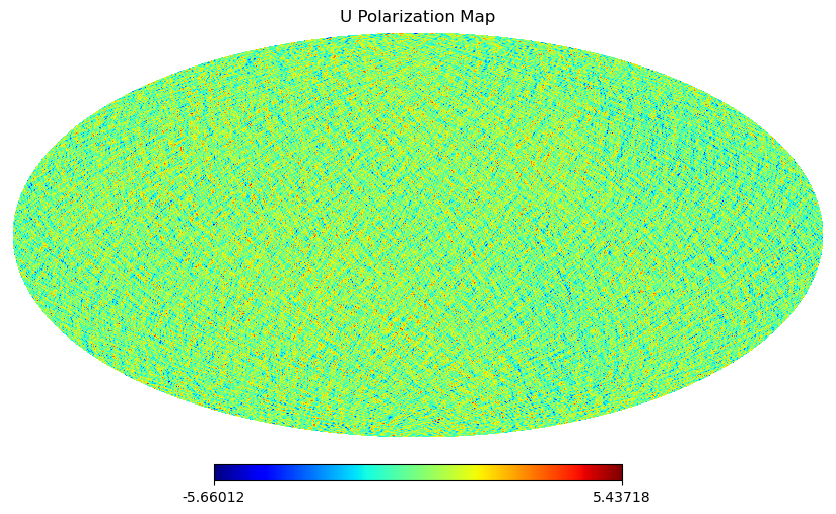

In [4]:
hp.mollview(
    smooth[0],
    max=np.max(smooth[0]),
    min=np.min(smooth[0]),
    cmap="jet",
    title="Temperature Map",
)
hp.mollview(
    smooth[1],
    max=np.max(smooth[1]),
    min=np.min(smooth[1]),
    cmap="jet",
    title="Q Polarization Map",
)
hp.mollview(
    smooth[2],
    max=np.max(smooth[2]),
    min=np.min(smooth[2]),
    cmap="jet",
    title="U Polarization Map",
)

In [6]:
# Finding 20000 hot and cold spots from smooth maps
top_index = np.argsort(smooth[0])[-20000:]
bottom_index = np.argsort(smooth[0])[:20000]

In [7]:
max_stacked = np.zeros((200, 200))
min_stacked = np.zeros((200, 200))

In [12]:
for i in range(len(top_index)):
    # find angluar position of pixels
    max_long, max_lat = hp.pix2ang(512, top_index[i], lonlat=True)
    min_long, min_lat = hp.pix2ang(512, bottom_index[i], lonlat=True)
    # find position vector of given angular position
    max_pos = hp.ang2vec(max_long, max_lat, lonlat=True)
    min_pos = hp.ang2vec(min_long, min_lat, lonlat=True)
    # find neighbours within a 5x5 degrees about max point
    max_neighbours = hp.query_disc(512, max_pos, np.sqrt(2 * 2.5**2) * np.pi / 180)
    min_neighbours = hp.query_disc(512, min_pos, np.sqrt(2 * 2.5**2) * np.pi / 180)
    # create array of masked pixel values
    sub_max = np.full(hp.nside2npix(512), hp.UNSEEN)
    sub_min = np.full(hp.nside2npix(512), hp.UNSEEN)
    sub_max[max_neighbours] = smooth[max_neighbours]
    sub_min[min_neighbours] = smooth[min_neighbours]
    # default xsize = 200
    gnomview_max = hp.gnomview(
        sub_max,
        rot=(max_long, max_lat),
        reso=5 * 60 / 200,
        return_projected_map=True,
        no_plot=True,
    )
    gnomview_min = hp.gnomview(
        sub_min,
        rot=(min_long, min_lat),
        reso=5 * 60 / 200,
        return_projected_map=True,
        no_plot=True,
    )
    max_stacked += gnomview_max
    min_stacked += gnomview_min

IndexError: index 1161173 is out of bounds for axis 0 with size 3